#**GroupBy Model Feature Engineering**

**Version 2 - Final**

The Kaggle and GroupBy data used in this version have already been pre-processed and cleaned.

Kaggle data: df_ec_final.csv

GroupBy data: df_json_final.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/Colab Notebooks/GroupBy_final')

In [ ]:
# Import required libraries
# Basic libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

##Data Preparation

####Load data

In [ ]:
# Load Kaggle data
df_ec = pd.read_csv('df_ec_final.csv')
print(df_ec.shape)
df_ec.head()

(25323266, 42)


,event_time,product_id,category_id,product_brand,product_price,customerVisitorId,customerSessionId,unique_sess,totals_events,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view,totalViewProducts,totalViewProductRevenue,totalAddToCarts,totalAddToCartRevenue,totalRemoveFromCarts,totalRemoveFromCartRevenue,totalOrders,totalOrderRevenue,uniqueViewProducts,uniqueAddToCarts,uniqueRemoveFromCarts,uniqueOrders,event_year,event_month,event_day_of_week,event_day_of_month,event_day_of_year,event_hour,event_minute,event_second,event_micorsecond,weekend,holiday,timeOnSite,newSession,first_session_event,last_session_event,hits.isEntrance,customerSessionNumber
0,2019-10-01 00:00:00,5773203,1487580005134238553,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,46324001126dd6e6e-4dac-4778-8d2c-92e149dab885,0.0,1,0,0,0,0.0,0.00,7.0,16.67,1.0,0.95,19.0,39.21,0.0,7.0,1.0,19.0,2019,10,1,1,274,0,0,0,0,0,0,60.0,1.0,0.0,0.0,1,1.0
1,2019-10-01 00:00:00,5842144,1487580006317032337,irisk,1.59,385985999,d30965e8-1101-44ab-b45d-cc1bb9fae694,385985999d30965e8-1101-44ab-b45d-cc1bb9fae694,0.0,0,0,1,0,4.0,17.72,40.0,97.86,26.0,50.18,4.0,14.89,2.0,10.0,9.0,4.0,2019,10,1,1,274,0,0,0,0,0,0,120.0,1.0,0.0,0.0,1,1.0
2,2019-10-01 00:00:00,5842144,1487580006317032337,irisk,1.59,385985999,d30965e8-1101-44ab-b45d-cc1bb9fae694,385985999d30965e8-1101-44ab-b45d-cc1bb9fae694,0.0,0,0,1,0,4.0,17.72,40.0,97.86,26.0,50.18,4.0,14.89,2.0,10.0,9.0,4.0,2019,10,1,1,274,0,0,0,0,0,0,120.0,1.0,0.0,0.0,2,1.0
3,2019-10-01 00:00:00,5773351,1487580005134238553,runail,2.62,430174032,73dea1e7-664e-43f4-8b30-d32b9d5af04f,43017403273dea1e7-664e-43f4-8b30-d32b9d5af04f,0.0,0,0,1,0,13.0,32.78,2.0,5.24,2.0,5.40,0.0,0.00,9.0,2.0,2.0,0.0,2019,10,1,1,274,0,0,0,0,0,0,60.0,1.0,0.0,0.0,1,1.0
4,2019-10-01 00:00:00,5698989,1487580006317032337,irisk,1.27,385985999,d30965e8-1101-44ab-b45d-cc1bb9fae694,385985999d30965e8-1101-44ab-b45d-cc1bb9fae694,0.0,0,0,1,0,4.0,17.72,40.0,97.86,26.0,50.18,4.0,14.89,2.0,10.0,9.0,4.0,2019,10,1,1,274,0,0,0,0,0,0,120.0,1.0,0.0,0.0,3,1.0


In [ ]:
df_ec.describe()

,product_id,category_id,product_price,customerVisitorId,totals_events,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view,totalViewProducts,totalViewProductRevenue,totalAddToCarts,totalAddToCartRevenue,totalRemoveFromCarts,totalRemoveFromCartRevenue,totalOrders,totalOrderRevenue,uniqueViewProducts,uniqueAddToCarts,uniqueRemoveFromCarts,uniqueOrders,event_year,event_month,event_day_of_week,event_day_of_month,event_day_of_year,event_hour,event_minute,event_second,event_micorsecond,weekend,holiday,timeOnSite,newSession,first_session_event,last_session_event,hits.isEntrance,customerSessionNumber
count,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,25323266.0,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,25323266.0,25323266.0,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07,2.532327e+07
mean,5.483749e+06,1.553466e+18,8.459103e+00,5.188454e+08,0.0,2.794151e-01,6.355515e-02,1.936648e-01,4.633649e-01,1.981657e+01,1.555718e+02,2.462946e+01,9.884926e+01,2.717991e+01,1.158432e+02,4.933089e+00,2.028087e+01,1.084692e+01,1.449232e+01,1.085936e+01,3.469635e+00,2.019332e+03,7.816992e+00,2.959184e+00,1.581468e+01,2.229967e+02,1.309032e+01,2.514439e+00,0.0,0.0,2.653894e-01,5.347438e-02,2.446593e+05,2.846052e-01,5.347438e-02,1.519156e-04,3.877952e+01,3.192934e+01
std,1.305727e+06,1.682317e+17,1.927622e+01,8.719654e+07,0.0,4.487118e-01,2.439588e-01,3.951693e-01,4.986561e-01,1.101983e+02,1.217356e+03,9.326147e+01,3.607008e+02,1.262441e+02,5.278499e+02,1.726898e+01,7.565289e+01,5.081468e+01,4.644897e+01,4.198265e+01,1.180207e+01,4.710961e-01,4.505367e+00,1.966298e+00,8.720193e+00,1.369782e+02,5.469739e+00,1.707971e+00,0.0,0.0,4.415403e-01,2.249775e-01,1.478477e+06,4.512262e-01,2.249775e-01,1.232447e-02,1.429379e+02,3.722389e+02
min,3.752000e+03,1.487580e+18,-7.937000e+01,4.654960e+05,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.937000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.333000e+01,0.000000e+00,-1.283000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,5.724626e+06,1.487580e+18,2.050000e+00,4.793546e+08,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,6.970000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,2.000000e+00,1.000000e+00,8.000000e+00,4.500000e+01,9.000000e+00,1.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00
50%,5.810673e+06,1.487580e+18,3.980000e+00,5.512287e+08,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,3.144000e+01,6.000000e+00,2.316000e+01,2.000000e+00,8.880000e+00,0.000000e+00,0.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,2.019000e+03,1.100000e+01,3.000000e+00,1.600000e+01,3.050000e+02,1.300000e+01,3.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,1.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00
75%,5.857360e+06,1.487580e+18,6.890000e+00,5.742531e+08,0.0,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.600000e+01,1.121000e+02,2.100000e+01,8.121000e+01,1.600000e+01,7.112000e+01,0.000000e+00,0.000000e+00,1.000000e+01,1.300000e+01,9.000000e+00,0.000000e+00,2.020000e+03,1.100000e+01,5.000000e+00,2.300000e+01,3.270000e+02,1.800000e+01,4.000000e+00,0.0,0.0,1.000000e+00,0.000000e+00,3.540000e+03,1.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,1.300000e+01
max,5.932595e+06,2.242903e+18,3.277800e+02,6.220

In [ ]:
# Load GroupBy data
df_json = pd.read_csv('df_json_final.csv')
print(df_json.shape)
df_json.head()

(1578809, 39)


,product_id,product_name,product_price,product_brand,hitSequence,first_session_event,last_session_event,hits.totalitems,total_price_cart,customerVisitorId,customerSessionId,customerSessionNumber,totals_events,newSession,totalViewProducts,totalViewProductRevenue,uniqueViewProducts,totalAddToCarts,totalAddToCartRevenue,uniqueAddToCarts,totalOrders,totalOrderRevenue,uniqueOrders,event_type_cart,event_type_purchase,hits.eventType.category_search,event_type_view,timeOnSite,event_year,event_month,event_day_of_week,event_day_of_month,event_day_of_year,event_hour,event_minute,event_second,event_micorsecond,weekend,holiday
0,BR013,nutritional yeast seasoning,4.99,Bragg,1,1,1,NaN,0.0,cki6s4tr200013bdpkaye9mdn,cki6s4tr200013bdpkaye9mdn1606878184,1,1,1,1,4.99,1,0,0.0,0,0,0.0,0,0,0,0,1,0.0,2020,12,2,2,337,3,3,4,0,0,0
1,DRB004,pure castile bar soap peppermint,4.50,Dr. Bronner's,1,1,1,NaN,0.0,cki6rrijb000125c5cdol7ahd,cki6rrijb000125c5cdol7ahd1606874797,1,1,1,1,4.50,1,0,0.0,0,0,0.0,0,0,0,0,1,0.0,2020,12,2,2,337,2,6,37,0,0,0
2,SUS022,100% daily value multi-vitamin,8.39,Superior Source,1,1,1,NaN,0.0,cki6uboil00013he8jwwj434w,cki6uboil00013he8jwwj434w1606878983,1,1,1,1,8.39,1,0,0.0,0,0,0.0,0,0,0,0,1,0.0,2020,12,2,2,337,3,16,23,0,0,0
3,NLS002,natural elderberry concentrate blend,11.99,Natural Sources,1,1,1,NaN,0.0,cki6vcrm500013vcysh1hk38z,cki6vcrm500013vcysh1hk38z1606880825,1,1,1,1,11.99,1,0,0.0,0,0,0.0,0,0,0,0,1,0.0,2020,12,2,2,337,3,47,5,0,0,0
4,MOM002,organic hair remover with tea tree refill jar,10.49,Moom,1,1,1,NaN,0.0,cki6vggk900013xe68nl4dao3,cki6vggk900013xe68nl4dao31606880997,1,1,1,1,10.49,1,0,0.0,0,0,0.0,0,0,0,0,1,0.0,2020,12,2,2,337,3,49,57,0,0,0


In [ ]:
df_json.describe()

,product_price,hitSequence,first_session_event,last_session_event,hits.totalitems,total_price_cart,customerSessionNumber,totals_events,newSession,totalViewProducts,totalViewProductRevenue,uniqueViewProducts,totalAddToCarts,totalAddToCartRevenue,uniqueAddToCarts,totalOrders,totalOrderRevenue,uniqueOrders,event_type_cart,event_type_purchase,hits.eventType.category_search,event_type_view,timeOnSite,event_year,event_month,event_day_of_week,event_day_of_month,event_day_of_year,event_hour,event_minute,event_second,event_micorsecond,weekend,holiday
count,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,39628.000000,1.578809e+06,1578809.0,1.578809e+06,1578809.0,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1.578809e+06,1578809.0,1578809.0,1578809.0,1578809.0,1578809.0,1.578809e+06,1.578809e+06,1.578809e+06,1578809.0,1578809.0,1578809.0
mean,1.391845e+01,1.689464e+01,1.741876e-01,1.316657e-01,4.027354,1.135662e+00,1.0,3.315296e+01,1.0,1.076912e+01,1.407915e+02,6.928027e+00,2.906811e+00,3.255539e+01,2.593484e+00,2.167462e+00,2.343963e+01,2.160204e+00,1.392885e-02,1.117108e-02,9.108588e-01,6.404131e-02,1.987493e+03,2020.0,12.0,2.0,2.0,337.0,6.543057e+00,2.990725e+01,2.953207e+01,0.0,0.0,0.0
std,1.210950e+01,2.312150e+01,3.792709e-01,3.381271e-01,5.428085,1.290852e+01,0.0,3.675860e+01,0.0,1.399953e+01,2.076066e+02,9.071962e+00,4.495616e+00,5.550465e+01,3.872447e+00,4.322050e+00,5.123814e+01,4.283799e+00,1.171958e-01,1.051013e-01,2.849476e-01,2.448266e-01,2.443512e+03,0.0,0.0,0.0,0.0,0.0,5.603894e+00,1.719315e+01,1.729832e+01,0.0,0.0,0.0
min,6.600000e-01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,1.0,1.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2020.0,12.0,2.0,2.0,337.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
25%,6.365000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,1.0,8.000000e+00,1.0,2.000000e+00,1.503000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.800000e+02,2020.0,12.0,2.0,2.0,337.0,2.000000e+00,1.500000e+01,1.500000e+01,0.0,0.0,0.0
50%,1.042632e+01,8.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,1.0,2.100000e+01,1.0,6.000000e+00,6.598000e+01,4.000000e+00,1.000000e+00,1.299000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.220000e+03,2020.0,12.0,2.0,2.0,337.0,4.000000e+00,3.000000e+01,3.000000e+01,0.0,0.0,0.0
75%,1.731333e+01,2.200000e+01,0.000000e+00,0.000000e+00,5.000000,0.000000e+00,1.0,4.400000e+01,1.0,1.500000e+01,1.758900e+02,9.000000e+00,4.000000e+00,4.502000e+01,4.000000e+00,3.000000e+00,3.283000e+01,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.689000e+03,2020.0,12.0,2.0,2.0,337.0,1.300000e+01,4.500000e+01,4.400000e+01,0.0,0.0,0.0
max,2.332000e+02,2.390000e+02,1.000000e+00,1.000000e+00,48.000000,7.446200e+02,1.0,2.390000e+02,1.0,1.030000e+02,1.741810e+03,7.100000e+01,5.400000e+01,7.488800e+02,4.700000e+01,4.800000e+01,7.446200e+02,4.800000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.649400e+04,2020.0,12.0,2.0,2.0,337.0,1.700000e+01,5.900000e+01,5.900000e+01,0.0,0.0,0.0


####Select columns that are common to both data sets

In [ ]:
# Select and re-arrange columns so they are in the same order (to make it easier to select columns for encoding)
json_cols = list(df_json.columns)
kaggle_cols = list(df_ec.columns)
column_names = set.intersection(set(json_cols), set(kaggle_cols))

df_ec = df_ec[column_names]
df_json = df_json[column_names]

print(df_ec.shape, df_json.shape)

(25323266, 34) (1578809, 34)


In [ ]:
column_names

{'customerSessionId',
 'customerSessionNumber',
 'customerVisitorId',
 'event_day_of_month',
 'event_day_of_week',
 'event_day_of_year',
 'event_hour',
 'event_micorsecond',
 'event_minute',
 'event_month',
 'event_second',
 'event_type_cart',
 'event_type_purchase',
 'event_type_view',
 'event_year',
 'first_session_event',
 'holiday',
 'last_session_event',
 'newSession',
 'product_brand',
 'product_id',
 'product_price',
 'timeOnSite',
 'totalAddToCartRevenue',
 'totalAddToCarts',
 'totalOrderRevenue',
 'totalOrders',
 'totalViewProductRevenue',
 'totalViewProducts',
 'totals_events',
 'uniqueAddToCarts',
 'uniqueOrders',
 'uniqueViewProducts',
 'weekend'}

##Data Encoding

####Categorical data

The categorical data need to be encoded for use in the machine learning model. For this project, Leave One Out Encoding will be used because:
- The encoded data stays in one column, preventing excessive increase of dimensionality
- It does not introduce unexisting mathematical relationships between the samples
- It can help reduce overfitting and data leakage

(ref. https://heartbeat.fritz.ai/hands-on-with-feature-engineering-advanced-methods-in-python-for-machine-learning-e05bf12da06a).


In [ ]:
# Categorical features
categorical_feat = ['customerVisitorId','customerSessionId','product_id', 'product_brand']
print(df_ec[categorical_feat].dtypes)
df_json[categorical_feat].dtypes

customerVisitorId     int64
customerSessionId    object
product_id            int64
product_brand        object
dtype: object


customerVisitorId    object
customerSessionId    object
product_id           object
product_brand        object
dtype: object

In [ ]:
# Convert customerVisitorId and product_id in the Kaggle data to object type, 
# as these features will be treated differently from the numerical data
df_ec['customerVisitorId'] = df_ec['customerVisitorId'].astype(str)
df_ec['product_id'] = df_ec['product_id'].astype(str)

In [ ]:
!pip install -U category_encoders

In [ ]:
# Apply Leave One Out Encoder to categorize the relevant columns
from category_encoders import LeaveOneOutEncoder

encoder = LeaveOneOutEncoder(return_df=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Separate the target variable to fit the encoder
X_ec_encoder = df_ec[categorical_feat]
y_ec_encoder = df_ec['event_type_purchase']
X_json_encoder = df_json[categorical_feat]
y_json_encoder = df_json['event_type_purchase']

In [ ]:
# Fit encoder for each set
X_ec_encoder_new = encoder.fit_transform(X_ec_encoder, y_ec_encoder)
X_json_encoder_new = encoder.fit_transform(X_json_encoder, y_json_encoder)

In [ ]:
# Replace Kaggle dataframe with encoded data
df_ec[categorical_feat] = X_ec_encoder_new
df_ec.head()

,customerVisitorId,totalOrders,event_hour,totalViewProducts,uniqueViewProducts,newSession,totalAddToCarts,weekend,product_price,holiday,first_session_event,event_type_cart,customerSessionId,product_brand,event_month,totalOrderRevenue,customerSessionNumber,uniqueAddToCarts,event_type_view,last_session_event,event_day_of_week,totals_events,event_micorsecond,timeOnSite,event_minute,totalViewProductRevenue,event_day_of_year,event_year,totalAddToCartRevenue,event_second,product_id,uniqueOrders,event_day_of_month,event_type_purchase
0,0.730769,19.0,0,0.0,0.0,1.0,7.0,0,2.62,0,0.0,1,0.730769,0.076128,10,39.21,1.0,7.0,0,0.0,1,0.0,0,60.0,0,0.00,274,2019,16.67,0,0.081319,19.0,1,0
1,0.063063,4.0,0,4.0,2.0,1.0,40.0,0,1.59,0,0.0,0,0.054795,0.078227,10,14.89,1.0,10.0,0,0.0,1,0.0,0,120.0,0,17.72,274,2019,97.86,0,0.070755,4.0,1,0
2,0.063063,4.0,0,4.0,2.0,1.0,40.0,0,1.59,0,0.0,0,0.054795,0.078227,10,14.89,1.0,10.0,0,0.0,1,0.0,0,120.0,0,17.72,274,2019,97.86,0,0.070755,4.0,1,0
3,0.000000,0.0,0,13.0,9.0,1.0,2.0,0,2.62,0,0.0,0,0.000000,0.076128,10,0.00,1.0,2.0,0,0.0,1,0.0,0,60.0,0,32.78,274,2019,5.24,0,0.065660,0.0,1,0
4,0.063063,4.0,0,4.0,2.0,1.0,40.0,0,1.27,0,0.0,0,0.054795,0.078227,10,14.89,1.0,10.0,0,0.0,1,0.0,0,120.0,0,17.72,274,2019,97.86,0,0.086634,4.0,1,0


In [ ]:
# Replace GroupBy dataframe with encoded data
df_json[categorical_feat] = X_json_encoder_new
df_json.head()

,customerVisitorId,totalOrders,event_hour,totalViewProducts,uniqueViewProducts,newSession,totalAddToCarts,weekend,product_price,holiday,first_session_event,event_type_cart,customerSessionId,product_brand,event_month,totalOrderRevenue,customerSessionNumber,uniqueAddToCarts,event_type_view,last_session_event,event_day_of_week,totals_events,event_micorsecond,timeOnSite,event_minute,totalViewProductRevenue,event_day_of_year,event_year,totalAddToCartRevenue,event_second,product_id,uniqueOrders,event_day_of_month,event_type_purchase
0,0.000000,0,3,1,1,1,0,0,4.99,0,1,0,0.011171,0.133523,12,0.0,1,0,1,1,2,1,0,0.0,3,4.99,337,2020,0.0,4,0.015291,0,2,0
1,0.000000,0,2,1,1,1,0,0,4.50,0,1,0,0.011171,0.162651,12,0.0,1,0,1,1,2,1,0,0.0,6,4.50,337,2020,0.0,37,0.009346,0,2,0
2,0.011171,0,3,1,1,1,0,0,8.39,0,1,0,0.011171,0.228571,12,0.0,1,0,1,1,2,1,0,0.0,16,8.39,337,2020,0.0,23,0.000000,0,2,0
3,0.000000,0,3,1,1,1,0,0,11.99,0,1,0,0.011171,0.034653,12,0.0,1,0,1,1,2,1,0,0.0,47,11.99,337,2020,0.0,5,0.010526,0,2,0
4,0.011171,0,3,1,1,1,0,0,10.49,0,1,0,0.011171,0.000000,12,0.0,1,0,1,1,2,1,0,0.0,49,10.49,337,2020,0.0,57,0.000000,0,2,0


In [ ]:
df_ec.to_csv('df_ec_encoded_cat.csv',index =False)
df_json.to_csv('df_json_encoded_cat.csv',index =False)

##Data balancing

####Check class balance

In [ ]:
df_ec = pd.read_csv('df_ec_encoded_cat.csv')
df_json = pd.read_csv('df_json_encoded_cat.csv')

In [ ]:
print(df_ec.shape, df_json.shape)

(25323266, 34) (1578809, 34)


In [ ]:
# Determine the percentage of user journeys that resulted in purchase
X_ec = df_ec.drop('event_type_purchase', axis=1)
X_json = df_json.drop('event_type_purchase', axis=1)
y_ec = df_ec['event_type_purchase']
y_json = df_json['event_type_purchase']
print(f'Percentage of journeys in the Kaggle data resulting in purchase = {(np.sum(y_ec)*100)/len(y_ec):.2f}%')
print(f'Percentage of journeys in the GroupBy data resulting in purchase = {(np.sum(y_json)*100)/len(y_json):.2f}%')

Percentage of journeys in the Kaggle data resulting in purchase = 6.36%
Percentage of journeys in the GroupBy data resulting in purchase = 1.12%


The results above show that both data sets are heavily imbalanced. Use downsampling to balance the data before further processing.

###Downsampling

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
# Kaggle data
# fit and apply the transform
X_ec_under, y_ec_under = undersample.fit_resample(X_ec, y_ec)
print(X_ec_under.shape, y_ec_under.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(3218848, 33) (3218848,)


In [ ]:
# GroupBy data
X_json_under, y_json_under = undersample.fit_resample(X_json, y_json)
print(X_json_under.shape, y_json_under.shape)

(35274, 33) (35274,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Determine the percentage of user journeys that resulted in purchase
print(f'Percentage of journeys in the Kaggle data resulting in purchase = {(np.sum(y_ec_under)*100)/len(y_ec_under):.2f}%')
print(f'Percentage of journeys in the GroupBy data resulting in purchase = {(np.sum(y_json_under)*100)/len(y_json_under):.2f}%')

Percentage of journeys in the Kaggle data resulting in purchase = 50.00%
Percentage of journeys in the GroupBy data resulting in purchase = 50.00%


##Data scaling

In [ ]:
# Convert downsampled data to dataframes
X_ec_under = pd.DataFrame(data=X_ec_under, columns=X_ec.columns)
y_ec_under = pd.DataFrame(data=y_ec_under, columns=['event_type_purchase'])
X_json_under = pd.DataFrame(data=X_json_under, columns=X_json.columns)
y_json_under = pd.DataFrame(data=y_json_under, columns=['event_type_purchase'])
print(X_ec_under.shape, y_ec_under.shape, X_json_under.shape, y_json_under.shape)

(3218848, 33) (3218848, 1) (35274, 33) (35274, 1)


In [ ]:
X_json_under.describe()

,customerVisitorId,totalOrders,event_hour,totalViewProducts,uniqueViewProducts,newSession,totalAddToCarts,weekend,product_price,holiday,first_session_event,event_type_cart,customerSessionId,product_brand,event_month,totalOrderRevenue,customerSessionNumber,uniqueAddToCarts,event_type_view,last_session_event,event_day_of_week,totals_events,event_micorsecond,timeOnSite,event_minute,totalViewProductRevenue,event_day_of_year,event_year,totalAddToCartRevenue,event_second,product_id,uniqueOrders,event_day_of_month
count,35274.000000,35274.000000,35274.000000,35274.000000,35274.000000,35274.0,35274.000000,35274.0,35274.000000,35274.0,35274.000000,35274.000000,35274.000000,35274.000000,35274.0,35274.000000,35274.0,35274.000000,35274.000000,35274.000000,35274.0,35274.000000,35274.0,35274.000000,35274.000000,35274.000000,35274.0,35274.0,35274.000000,35274.000000,35274.000000,35274.000000,35274.0
mean,0.069572,5.057464,6.055678,9.993933,6.113370,1.0,3.706328,0.0,12.977170,0.0,0.146113,0.006492,0.095747,0.108506,12.0,55.928033,1.0,3.299626,0.030986,0.520894,2.0,29.204371,0.0,1859.322447,29.859330,127.085732,337.0,2020.0,42.459074,29.140387,0.019203,5.033481,2.0
std,0.187718,6.420345,5.347072,12.739157,7.978236,0.0,5.034840,0.0,11.908713,0.0,0.353225,0.080312,0.237327,0.139694,0.0,81.258722,0.0,4.199934,0.173282,0.499570,0.0,32.508580,0.0,2169.961728,17.361364,184.096248,0.0,0.0,66.150338,17.250574,0.053708,6.324155,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.670000,0.0,0.000000,0.000000,0.000000,0.000000,12.0,0.000000,1.0,0.000000,0.000000,0.000000,2.0,1.000000,0.0,0.000000,0.000000,0.000000,337.0,2020.0,0.000000,0.000000,0.000000,0.000000,2.0
25%,0.000000,0.000000,2.000000,2.000000,1.000000,1.0,0.000000,0.0,5.790000,0.0,0.000000,0.000000,0.000000,0.000000,12.0,0.000000,1.0,0.000000,0.000000,0.000000,2.0,7.000000,0.0,458.000000,15.000000,13.990000,337.0,2020.0,0.000000,14.000000,0.001629,0.000000,2.0
50%,0.013841,4.000000,4.000000,6.000000,3.000000,1.0,2.000000,0.0,9.688333,0.0,0.000000,0.000000,0.013889,0.075472,12.0,35.830000,1.0,2.000000,0.000000,1.000000,2.0,19.000000,0.0,1223.000000,30.000000,62.890000,337.0,2020.0,22.030000,29.000000,0.012037,4.000000,2.0
75%,0.042308,7.000000,11.000000,13.000000,8.000000,1.0,5.000000,0.0,15.930000,0.0,0.000000,0.000000,0.049751,0.217286,12.0,75.250000,1.0,5.000000,0.000000,1.000000,2.0,39.000000,0.0,2493.000000,45.000000,166.080000,337.0,2020.0,57.380000,44.000000,0.022727,7.000000,2.0
max,1.000000,48.000000,17.000000,103.000000,71.000000,1.0,54.000000,0.0,233.200000,0.0,1.000000,1.000000,1.000000,1.000000,12.0,744.620000,1.0,47.000000,1.000000,1.000000,2.0,239.000000,0.0,16494.000000,59.000000,1741.810000,337.0,2020.0,748.880000,59.000000,0.717391,48.000000,2.0


In [ ]:
X_json_under.columns

Index(['customerVisitorId', 'totalOrders', 'event_hour', 'totalViewProducts',
       'uniqueViewProducts', 'newSession', 'totalAddToCarts', 'weekend',
       'product_price', 'holiday', 'first_session_event', 'event_type_cart',
       'customerSessionId', 'product_brand', 'event_month',
       'totalOrderRevenue', 'customerSessionNumber', 'uniqueAddToCarts',
       'event_type_view', 'last_session_event', 'event_day_of_week',
       'totals_events', 'event_micorsecond', 'timeOnSite', 'event_minute',
       'totalViewProductRevenue', 'event_day_of_year', 'event_year',
       'totalAddToCartRevenue', 'event_second', 'product_id', 'uniqueOrders',
       'event_day_of_month'],
      dtype='object')

In [ ]:
# Select columns to scale
# Exclude categorical and binary features
columns_to_scale = ['totalOrders', 'event_hour', 'totalViewProducts', 'uniqueViewProducts', 
                    'totalAddToCarts', 'product_price', 'event_month', 'totalOrderRevenue', 
                    'uniqueAddToCarts', 'event_day_of_week', 'totals_events', 'event_micorsecond', 
                    'timeOnSite', 'event_minute', 'totalViewProductRevenue', 'event_day_of_year', 
                    'event_year', 'totalAddToCartRevenue', 'event_second', 'uniqueOrders',
                    'event_day_of_month']

X_ec_numerical = X_ec_under[columns_to_scale]
X_json_numerical = X_json_under[columns_to_scale]

In [ ]:
from sklearn.preprocessing import normalize

# Kaggle data
X_ec_numerical_norm = normalize(X_ec_numerical, axis=0, norm='max')
X_ec_numerical_norm = pd.DataFrame(data=X_ec_numerical_norm, columns=columns_to_scale)

In [ ]:
#GroupBy data
X_json_numerical_norm = normalize(X_json_numerical, axis=0, norm='max')
X_json_numerical_norm = pd.DataFrame(data=X_json_numerical_norm, columns=columns_to_scale)

In [ ]:
# Update the Kaggle independent variables dataframe
X_ec = X_ec_under
X_ec[columns_to_scale] = X_ec_numerical_norm[columns_to_scale]

In [ ]:
# Update the GroupBy independent variables dataframe
X_json = X_json_under
X_json[columns_to_scale] = X_json_numerical_norm[columns_to_scale]

In [ ]:
y_ec = y_ec_under
y_json = y_json_under

In [ ]:
# Save data to csv
X_ec.to_csv('X_ec.csv', index=False)
y_ec.to_csv('y_ec.csv', index=False)
X_json.to_csv('X_json.csv', index=False)
y_json.to_csv('y_json.csv', index=False)

##Feature Importance Ranking

In [ ]:
X_ec = pd.read_csv('X_ec.csv')
y_ec = pd.read_csv('y_ec.csv')
X_json = pd.read_csv('X_json.csv')
y_json = pd.read_csv('y_json.csv')

In [ ]:
# Define function for feature importances

# Use Random Forest to get feature ranks/importances for each feature
from sklearn.ensemble import ExtraTreesClassifier

def feature_importances(X, y):
  # Build a forest and compute the impurity-based feature importances
  forest = ExtraTreesClassifier(n_estimators=20, random_state=0)
  # Fit forest
  forest.fit(X, y)
  importances = forest.feature_importances_
  std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print('Feature ranking:')

  for f in range(X.shape[1]):
    print(f'{f+1:.0f}. feature {indices[f]:.0f} ({importances[indices[f]]:f})')

  # Plot the impurity-based feature importances of the forest
  plt.figure()
  plt.title('Feature importances')
  plt.bar(range(X.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

  return importances, indices

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Feature ranking:
1. feature 12 (0.300482)
2. feature 18 (0.253342)
3. feature 11 (0.158768)
4. feature 0 (0.090115)
5. feature 31 (0.045467)
6. feature 15 (0.040550)
7. feature 1 (0.040234)
8. feature 24 (0.007660)
9. feature 5 (0.005911)
10. feature 13 (0.005289)
11. feature 30 (0.005054)
12. feature 2 (0.004737)
13. feature 17 (0.004640)
14. feature 6 (0.004099)
15. feature 4 (0.003981)
16. feature 23 (0.003670)
17. feature 8 (0.003631)
18. feature 28 (0.003629)
19. feature 3 (0.003575)
20. feature 25 (0.002749)
21. feature 26 (0.002511)
22. feature 32 (0.002423)
23. feature 16 (0.002244)
24. feature 20 (0.002096)
25. feature 14 (0.001649)
26. feature 7 (0.000688)
27. feature 27 (0.000315)
28. feature 9 (0.000245)
29. feature 10 (0.000243)
30. feature 19 (0.000002)
31. feature 21 (0.000000)
32. feature 22 (0.000000)
33. feature 29 (0.000000)


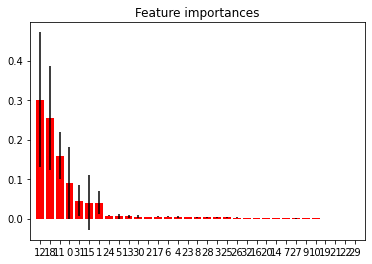

In [ ]:
# Feature importance ranking on Kaggle data
importances_ec, indices_ec = feature_importances(X_ec, y_ec)

In [ ]:
# Top 5 important features on Kaggle data
print('Top features on Kaggle data:')
for i in range(5):
  print(f'{i+1}. {X_ec.columns[indices_ec[i]]}')

Top features on Kaggle data:
1. customerSessionId
2. event_type_view
3. event_type_cart
4. customerVisitorId
5. uniqueOrders


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Feature ranking:
1. feature 19 (0.345023)
2. feature 13 (0.320465)
3. feature 0 (0.055120)
4. feature 31 (0.048104)
5. feature 1 (0.045779)
6. feature 12 (0.039625)
7. feature 15 (0.029480)
8. feature 18 (0.028729)
9. feature 10 (0.015525)
10. feature 17 (0.011185)
11. feature 6 (0.011146)
12. feature 28 (0.009076)
13. feature 21 (0.006102)
14. feature 23 (0.005397)
15. feature 2 (0.005055)
16. feature 3 (0.004307)
17. feature 24 (0.003808)
18. feature 4 (0.003361)
19. feature 30 (0.003122)
20. feature 25 (0.002827)
21. feature 29 (0.002776)
22. feature 11 (0.002472)
23. feature 8 (0.001518)
24. feature 5 (0.000000)
25. feature 7 (0.000000)
26. feature 32 (0.000000)
27. feature 9 (0.000000)
28. feature 14 (0.000000)
29. feature 20 (0.000000)
30. feature 22 (0.000000)
31. feature 26 (0.000000)
32. feature 27 (0.000000)
33. feature 16 (0.000000)


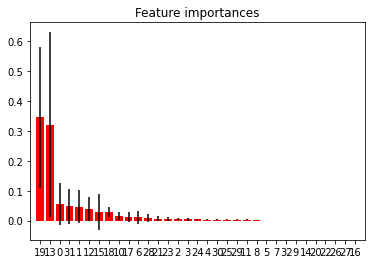

In [ ]:
# Feature importance ranking on GroupBy data
importances_json, indices_json = feature_importances(X_json, y_json)

In [ ]:
# Top 5 important features on GroupBy data
print('Top features on GroupBy data:')
for i in range(5):
  print(f'{i+1}. {X_json.columns[indices_json[i]]}')

Top features on GroupBy data:
1. last_session_event
2. product_brand
3. customerVisitorId
4. uniqueOrders
5. totalOrders


The rankings above provide some understanding of the importance of the features between data sets. However, since the number of available features is not too great, all features in the engineered data sets will be used for prediction. In order to reduce overfitting, regularization will be used in the deep learning model.

The engineered data sets will be used in the predictor model.